<a href="https://colab.research.google.com/github/alifele/MedicalPhysicsCodes/blob/main/radio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
N1_0 = 100.0
N2_0 = 0.0
lambda1 = 40
lambda2 = 30
dt = 0.0001
N1 = [N1_0]
N2 = [N2_0]

In [ ]:
for i in range(1000):
  dN1 = -lambda1 * N1[i] * dt
  N1.append(dN1 + N1[i])
  dN2 = -lambda2 * N2[i] * dt - dN1
  N2.append(dN2 + N2[i])

  

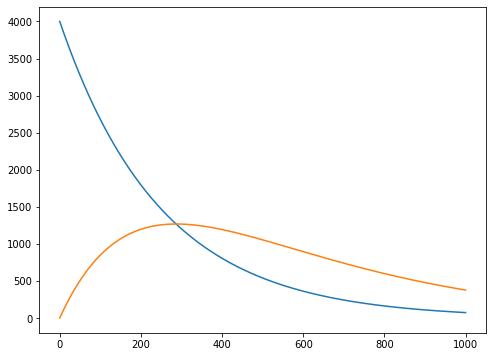

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(lambda1 * np.array(N1))
plt.plot(lambda2 * np.array(N2))

In [ ]:
Names = ["A","B","C"]
Branch = np.array([[0,1,0],[0,0,1],[0,0,0]])
Decay = np.array([[0,30,0],[0,0,20],[0,0,0]])
eff_Decay = (Branch @ Decay.T).diagonal()

In [ ]:
eff_Decay

array([30, 20,  0])

In [ ]:
N = np.array([[100,0,0],[0,0,0],[0,0,0]])
t_simulation = 0.5

In [ ]:
N_List = [N.sum(axis=1)]
t = 0
t_List = [t]
dt = 0.001

In [ ]:
for i in range(int(t_simulation/dt)):
  X = Decay.T @ N
  dN = (-Branch@X + Branch.T@X.T)*dt
  N = N + dN
  N_List.append(N_List[i] + dN.sum(axis=1))
  t_List.append(t_List[i] + dt)

In [ ]:
N_List = np.array(N_List)

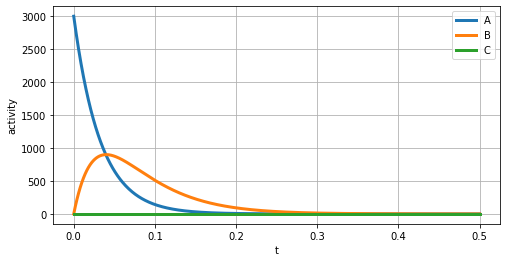

In [ ]:
plt.figure(figsize=(8,4))
for i in range(3):
  plt.plot(t_List, N_List[:,i] * eff_Decay[i], label=Names[i],lw=3)

plt.grid('on')
plt.xlabel("t")
plt.ylabel("activity")
plt.legend()

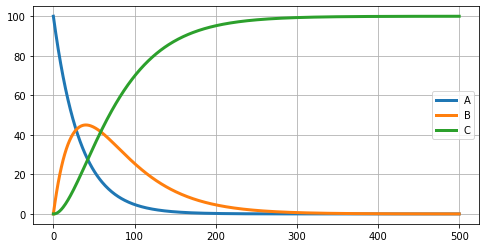

In [ ]:
plt.figure(figsize=(8,4))
for i in range(3):
  plt.plot(N_List[:,i], label=Names[i],lw=3)

plt.grid('on')
plt.legend()

In [ ]:
class Radio_Ensemble:
  def __init__(self):
    self.parents = dict()
    self.all_elements = set()
    self.lifeTime_unit = "day"
    self.t_List = []
    self.N_List = []


  def set_lifeTime_unit(self, unit): #unit: second, minute, hour, day, week, year
    self.lifeTime_unit = unit

  def add_parent(self, parent_daughter): # parent_daughter = [["parent_name", initial_activity], ["daughter_name", branching_ratio, life_time, initial_activity]]  --> daughter_activity will be assumed zero if noting entered
    self.extract_allElements(parent_daughter)
    self.parents[parent_daughter[0][0]] = Parent(parent_daughter)

  def Run(self, simulation_time, unit):
    self.simulation = Simulate(simulation_time, unit, self.lifeTime_unit, self.all_elements, self.parents)
    self.t_List, self.N_List, self.eff_Decay = self.simulation.run()

  def extract_allElements(self, parent_daughter):
    for elem in parent_daughter:
      self.all_elements.add(elem[0])


In [ ]:
class Parent:
  def __init__(self, parent_daughter):
    self.name = parent_daughter[0][0]
    self.amount = parent_daughter[0][1]
    self.daughters = dict()
    for elem in parent_daughter[1:]:
      self.add_daughter(elem)
  def add_daughter(self, daughter_info): # daughter_info = ["daughter_name", branching_ratio, life_time, <amount>]
    self.daughters[daughter_info[0]] = Daughter(self.name, daughter_info)

In [ ]:
class Daughter:
  def __init__(self, parent_name, daughter_info):
    self.parent_name = parent_name
    self.daughter_name = daughter_info[0]
    self.branching_ratio = daughter_info[1]
    self.life_time = daughter_info[2]
    self.decay_const = np.log(2)/self.life_time
    if len(daughter_info) > 3:
      self.amount = daughter_info[3]
    else:
      self.amount = 0.0

In [610]:
class Simulate:
  def __init__(self,simulation_time,unit,lifeTime_unit,all_elements,parents):
    self.unitOfTime = unit
    self.lifeTime_unit = lifeTime_unit
    self.simulation_time = self.simulationTimeOVERunitOfLifeTime(simulation_time)  # Normalized simulation time ( #unit of lifetime)
    self.all_elements = all_elements
    self.parents = parents
    self.Decay_Matrix = np.eye(len(self.all_elements))*0.0
    self.Branching_Matrix = np.eye(len(self.all_elements))*0.0
    self.N_Matrix = 0
    self.eff_Decay = 0

    self.numberOfSteps = 5000
    self.dt = self.simulation_time/self.numberOfSteps

  def simulationTimeOVERunitOfLifeTime(self, simulation_time): #unit: second, minute, hour, day, week, year  |||| simulationTime/unitOfLifeTime
    return self.X2second_converter(simulation_time,self.unitOfTime)/self.X2second_converter(1,self.lifeTime_unit)
    
  def X2second_converter(self, val, X):
    if X == "second":
      return  val
    if X == "minute":
      return val*60
    if X == "hour":
      return val*60*60
    if X == "day":
      return val*60*60*24 
    if X == "week":
      return val*60*60*24*7
    if X == "year":
      return val*60*60*24*365

  def second2X_converter(self, val, X):
    return val*val/self.X2second_converter(val,X)

  def calculate_N_Matrix(self):
    N_amount = np.zeros(len(self.all_elements))
    for Index, elemName in enumerate(list(self.all_elements)):
      if elemName in self.parents.keys():
        N_amount[Index] += self.parents[elemName].amount
        for daughterIndex, daughterName in enumerate(list(self.all_elements)):
          if daughterName in self.parents[elemName].daughters.keys():
            N_amount[daughterIndex] += self.parents[elemName].daughters[daughterName].amount
    
    self.N_Matrix = np.diag(N_amount)

  def calculate_DecayAndBranching_Matrix(self):
    for Index, elemName in enumerate(list(self.all_elements)):
      print(Index, elemName)
      if elemName in self.parents.keys():
        for daughterIndex, daughterName in enumerate(list(self.all_elements)):
          if daughterName in self.parents[elemName].daughters.keys():
            #print(elemName, Index, daughterName, daughterIndex)
            self.Decay_Matrix[Index,daughterIndex] = self.parents[elemName].daughters[daughterName].decay_const
            self.Branching_Matrix[Index,daughterIndex] = self.parents[elemName].daughters[daughterName].branching_ratio

  def run(self):
    self.calculate_N_Matrix()
    self.calculate_DecayAndBranching_Matrix()
    self.eff_Decay = (self.Branching_Matrix @ self.Decay_Matrix.T).diagonal()
    self.N_List = [self.N_Matrix.sum(axis=1)]
    self.t = 0
    self.t_List = [self.t]
    for i in range(self.numberOfSteps):
      X = self.Decay_Matrix.T @ self.N_Matrix
      dN = (-self.Branching_Matrix@X + self.Branching_Matrix.T@X.T)*self.dt
      self.N_Matrix = self.N_Matrix + dN
      self.N_List.append(self.N_List[i] + dN.sum(axis=1))
      self.t_List.append(self.t_List[i] + self.dt)

    self.t_List = np.array(self.t_List)
    self.t_List = self.t_List *(self.X2second_converter(1, self.lifeTime_unit)/self.X2second_converter(1, self.unitOfTime))
    self.N_List = np.array(self.N_List)

    return self.t_List, self.N_List, self.eff_Decay


In [611]:
Mybox = Radio_Ensemble()

In [612]:
Mybox.add_parent([["A",100],["B",1,1]])
Mybox.add_parent([["B",0],["C",1,12]])

In [613]:
Mybox.Run(10,'day')

0 C
1 A
2 B


In [614]:
list(Mybox.simulation.all_elements)

['C', 'A', 'B']

In [615]:
list(Mybox.all_elements)

['C', 'A', 'B']

In [616]:
Mybox.parents["A"].daughters

{'B': <__main__.Daughter at 0x7fac619d46a0>}

(0.0, 10.0)

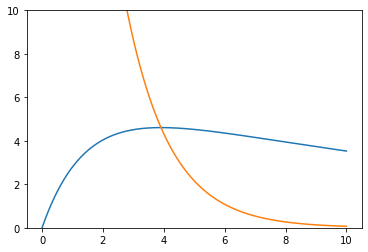

In [617]:
plt.plot(Mybox.t_List, Mybox.N_List[:,2]*Mybox.eff_Decay[2])
plt.plot(Mybox.t_List, Mybox.N_List[:,1]*Mybox.eff_Decay[1])
plt.ylim([0,10])